## Quantum Annealing using Qamomile and QuTip

From here, we will introduce applications in quantum annealing using Qamomile and QuTip. The Hamiltonian we are considering this time is of the following form

$$
H(s) = s H_0 + (1 - s) H_1
$$

where $ H_0 $ is the Hamiltonian for the Max-Cut problem we want to solve and often formulated in terms of an Ising model, and $ H_1 $ is the Hamiltonian for the transverse magnetic field.For further details on how to construct the Hamiltonian for the max-cut problem, please refer to [QAOA for Max-Cut](https://jij-inc.github.io/Qamomile/tutorial/maxcut.html).

$$
H_0 = \frac{1}{2} \sum_{(i,j) \in E} w_{i,j}(s_i s_j - 1)  , \quad H_1 = - \sum_{i=1}^N \sigma_i^x
$$


As $t$ increases and $1-t$ decreases, the system gradually evolves from the ground state of $H_1$ to the ground state of  $H_0$, which corresponds to the solution to the optimization problem. 

Quantum annealing relies on quantum tunneling to allow the system to escape local minima by passing through energy barriers, rather than needing to climb over them as in classical annealing.

First, let’s import the Qamomile library and other libraries used in this example.


In [1]:
import jijmodeling as jm
import numpy as np
import qamomile.core.operator as qm_o
import matplotlib.pyplot as plt
import qamomile.qutip as qm_qt

# N = 4
# J = {}
# h = {}

# for i in range(N-1):
#     for j in range(i+1, N):
#         J[(i, j)] = random.gauss(0, 1)

# for i in range(N):
#     h[i] = random.gauss(0, 1)

def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    w = jm.Placeholder("w", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut")
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, w[e[0], e[1]] * (1 + si * sj))
    problem += obj
    return problem


problem = Maxcut_problem()
problem

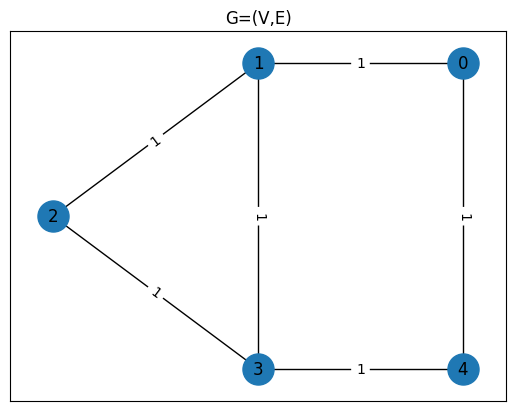

In [2]:
import networkx as nx
from IPython.display import display, Latex

G = nx.Graph()
num_nodes = 5
edges = [(0, 1, 1), (0, 4, 1), (1, 2, 1), (1, 3, 1), (2, 3, 1), (3, 4, 1)]
G.add_nodes_from(range(num_nodes))
G.add_weighted_edges_from(edges)

weight_matrix = nx.to_numpy_array(G)

edge_labels = nx.get_edge_attributes(G, "weight")
pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
plt.title("G=(V,E)")
plt.plot(figsize=(5, 4))

nx.draw_networkx(G, pos, node_size=500)
label_key = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

In [3]:
# Create data
V = num_nodes
E = edges
w = weight_matrix
data = {"V": V, "E": E, "w": w}
data

{'V': 5,
 'E': [(0, 1, 1), (0, 4, 1), (1, 2, 1), (1, 3, 1), (2, 3, 1), (3, 4, 1)],
 'w': array([[0., 1., 0., 0., 1.],
        [1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 1., 1., 0., 1.],
        [1., 0., 0., 1., 0.]])}

In [4]:
import jijmodeling_transpiler.core as jmt
compiled_model = jmt.compile_model(problem, data)

In [5]:
import qamomile.core as qm

# Obtain cost hamiltonian
qaoa_converter = qm.qaoa.QAOAConverter(compiled_model)
H0 = qaoa_converter.get_cost_hamiltonian()

Now transpile the qamomile’s hamiltonian to the qutip’s hamiltonian

In [6]:
qt_transpiler = qm_qt.QuTiPTranspiler()
qt_H0= qt_transpiler.transpile_hamiltonian(H0)

Same procedure for $H_1$

In [7]:
H1 = qm_o.Hamiltonian()
for q1 in range(V):
    H1 -= qm_o.X(q1)
qt_H1= qt_transpiler.transpile_hamiltonian(H1)


We can calculate the energy spectrum by using `eigenenergies` form QuTiP. We will examine how the eigenenergy of the Hamiltonian changes as the parameter $s$ varies from 0 to 1.


In [8]:
from qutip import *
slist = np.linspace(0.0, 1.0, 101)
Elists = [[] for i in range(2**V)]

for s in slist:
    qt_H = s*qt_H0 + (1-s)*qt_H1
    evals = qt_H.eigenenergies()
    for i in range(2**V):
        Elists[i].append(evals[i])

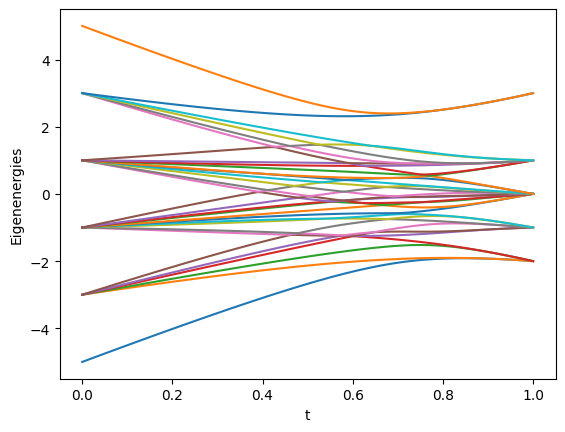

In [9]:
for i in range(2**V):
    plt.plot(slist, Elists[i], label=f"{i+1}th")

plt.xlabel("t")
plt.ylabel("Eigenenergies")
#plt.legend()
plt.show()


We can verify if the state corresponding to the ground energy is the optimal solution for the max-cut problem. According to the plot, there are four degenerate solutions. Let's examine the first eigenstate

In [10]:
evals, eigstates = qt_H0.eigenstates()
eket0 = eigstates[0]
state_vector = eket0.full().flatten()
indices_with_one = np.where(np.abs(state_vector) == 1.0)[0]

# Convert indices to their binary representation
qubit_states = [
    np.array(list(map(int, format(index, f'0{V}b'))))
    for index in indices_with_one
]

In [11]:
# Transform the qutip's state back to  
from qamomile.core.bitssample import BitsSample, BitsSampleSet
sample = BitsSample(1,qubit_states[0])
sample_set = BitsSampleSet(bitarrays=[sample])
transformed_state=qaoa_converter.decode_bits_to_sampleset(sample_set).data[0].var_values['x'].values

The result is the same as that obtained using [QAOA](https://jij-inc.github.io/Qamomile/tutorial/maxcut.html)

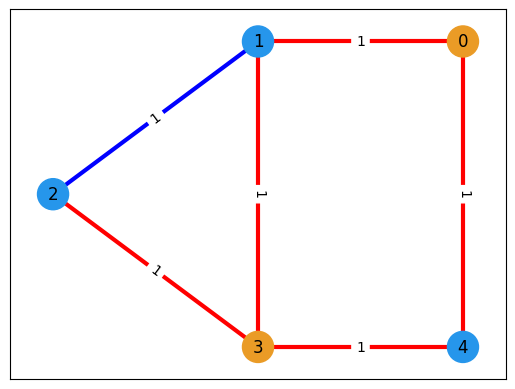

In [12]:
edge_colors = []

def get_edge_colors(
    graph, cut_solution, in_cut_color="r", not_in_cut_color="b"
) :
    cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9b26" for node in G.nodes()]
    return edge_colors, node_colors


edge_colors, node_colors = get_edge_colors(G, transformed_state)
plt.plot(figsize=(5, 4))
nx.draw_networkx(
    G,
    pos,
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)
label_key = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

Next, let's calculate the dynamics of quantum annealing and try to determine the success probability of the annealing. In the Hamiltonian $H(s)$ introduced earlier, we define the annealing time $T$ with $s = t / T$. In quantum annealing, if $T$ is taken sufficiently large, the ground state can theoretically be obtained with 100\% probability. Therefore, we adjust $T$ and perform quantum annealing, and we examine how much the final state $|\psi(T)\rangle$ overlaps with the ground state $|\phi_0\rangle$ of $H_0$ by looking at $|\langle \phi_0 | \psi(T) \rangle|^2$. We refer to this as the success probability of quantum annealing.

Quantum annealing follows the Schrödinger equation for time evolution, but with QuTiP, we can numerically solve this Schrödinger equation easily with simple code.



In [13]:
T = 100.0
def f0(t, args):
    return t/T

def f1(t, args):
    return 1 - t/T

The entire Hamiltonian is given as a list where each element is a pair consisting of a Hamiltonian and its coefficient.

We create the initial state $ \psi(t)$ at $t = 0$, which is the ground state of $H_1$.


In [14]:
H = [[qt_H0, f0], [qt_H1, f1]]
psi0 = tensor([Qobj([[1], [1]])/np.sqrt(2) for i in range(V)])

This time, we will not only look at the success probability but also examine how much $|\psi(t)\rangle$ overlaps with $|\phi_0\rangle$ at each moment. To solve the Schrödinger equation, we use `mesolve`. By providing the Hamiltonian to be solved (which may depend on time), the initial state, a list of times, a list of collapse operators (which is not relevant this time), and a list of operators for which we want to calculate the expectation values at each moment (this time, $\rho = |\phi_0\rangle \langle \phi_0|$, a function that converts the ket vector into a density operator), the dynamics can be calculated. `ket2dm` converts the ket vector to a density operator.


In [15]:
tlist = np.linspace(0.0, T, 101)
result = mesolve(H, psi0, tlist, [], [ket2dm(eket0)])

Among the calculation results, the expected value $|\langle \phi_0 | \psi(t) \rangle|^2$, which we wanted to calculate, is stored in `result.expect[0]`. Let's plot it.


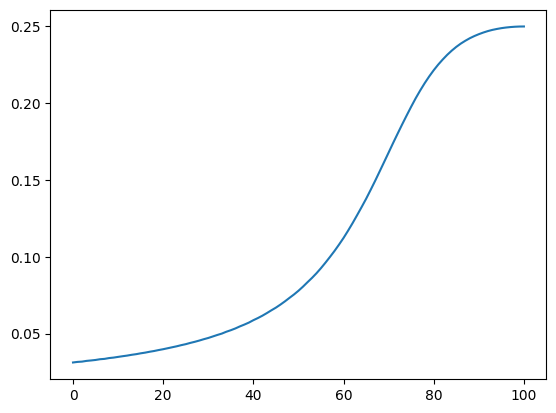

In [16]:
plt.plot(result.times, result.expect[0])
plt.show()

Masaphys. *PythonとQuTiPで量子アニーリングのダイナミクスを追う*. Qiita. Accessed October 30, 2024. [https://qiita.com/masaphys/items/38aeaee5313f81e15414](https://qiita.com/masaphys/items/38aeaee5313f81e15414)
